<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E8%BC%95%E6%B2%B9%E6%A1%88%E5%AD%90%E6%87%89%E7%94%A8PCA%E4%B8%BB%E6%88%90%E5%88%86%E5%88%86%E6%9E%90%E6%8F%90%E5%8D%87%E9%A0%90%E6%B8%AC%E7%B5%90%E6%9E%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [21]:
import pandas as pd

data = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)
mod  = data.index % 5
train = data.loc[ mod != 0 ,:]
test = data.loc[ mod == 0 ,:]
print(train.shape)
print(test.shape)

(200, 27)
(50, 27)


In [22]:
train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
1,74.9,105.9,138.6,39.082932,6.819271,5.891867,0.771648,5.836773,7.357714,6.355753,0.659941,5.309983,6.537441,11.889440,2.175804,5.337691,8.360263,9.078996,3.419692,2.224309,6.563137,4.008402,0.522953,0.057245,0.621373,0.165602,0.034701
2,60.4,97.9,144.4,40.934064,12.061397,8.788561,1.018949,6.671666,8.024599,10.116494,3.755812,4.855465,4.197693,12.283775,4.139793,3.781476,4.404284,3.863638,3.345833,2.205359,2.984103,1.368210,0.800960,0.414533,0.676800,0.070908,0.169692
3,100.4,114.0,137.0,53.849498,0.152985,0.054995,0.125987,2.097767,1.214444,7.428715,2.663734,6.475165,5.259181,15.397940,6.812319,7.602400,9.434827,8.037266,7.481252,3.877234,8.225184,3.917980,1.569843,0.421814,1.334506,0.127167,0.287296
4,105.7,127.5,154.6,44.225827,0.334270,0.215481,0.153186,2.306365,2.733433,3.013477,0.453959,4.235994,4.640280,8.692144,3.097721,6.825638,9.400184,8.999908,6.979372,5.567792,11.825300,7.673652,3.166715,1.524705,6.164731,0.415157,1.580535
6,106.0,125.4,159.8,54.454027,0.350789,0.220336,0.130728,1.183945,1.376936,3.548836,0.417912,3.073976,5.860175,12.842276,3.848192,4.339943,8.836537,10.087635,6.383659,3.155302,9.465907,7.226622,5.172914,1.604274,6.077852,0.922120,3.873133


# def features & y_columns & y_name

In [0]:
features = ['T10','T50','T90','N+A']
y_columns = ['C5NP','C5IP','C5N']
y_name = 'V1'

# 把幾個y 降維成 1個

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()
pca = PCA(n_components=1)

# fit & transform
train[y_name] = pca.fit_transform(scaler_y.fit_transform(train[y_columns]))
# transform
test[y_name] = pca.transform(scaler_y.transform(test[y_columns]))

# scaler features

In [0]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_x.fit(train[features])

train[features] = scaler_x.transform(train[features])
test[features] = scaler_x.transform(test[features])

# metric

In [0]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
def metric(y_t,y_p):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error':mean_absolute_error(y_t,y_p)}
  return pd.DataFrame(res,index=[y_t.name])

# modeling

In [29]:
import xgboost
from sklearn.svm import SVR
from sklearn.metrics.scorer import make_scorer
from math import sqrt
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
import warnings 
warnings.simplefilter('ignore')

#model = xgboost.XGBRegressor(objective='reg:squarederror')
model = SVR()
#model = LinearRegression()

#交叉驗證5次
val_scores = cross_validate(model,train[features],train[y_name],cv=5,
                            scoring = {'rmse': make_scorer(RMSE, greater_is_better=False)})

print('val_scores:',val_scores['test_rmse'])
print('val_scores.mean:',val_scores['test_rmse'].mean())

# fit 
model.fit(train[features],train[y_name])
# predict
test['y_pred'] = model.predict(test[features])

# metric
print('test_scores:')
metric(test[y_name],test['y_pred'])

val_scores: [-0.45612861 -0.56529545 -0.33473186 -0.18733698 -0.24042576]
val_scores.mean: -0.3567837327707066
test_scores:


,R2,RMSE,mean_absolute_error
V1,0.897437,0.499008,0.249879


# line plot

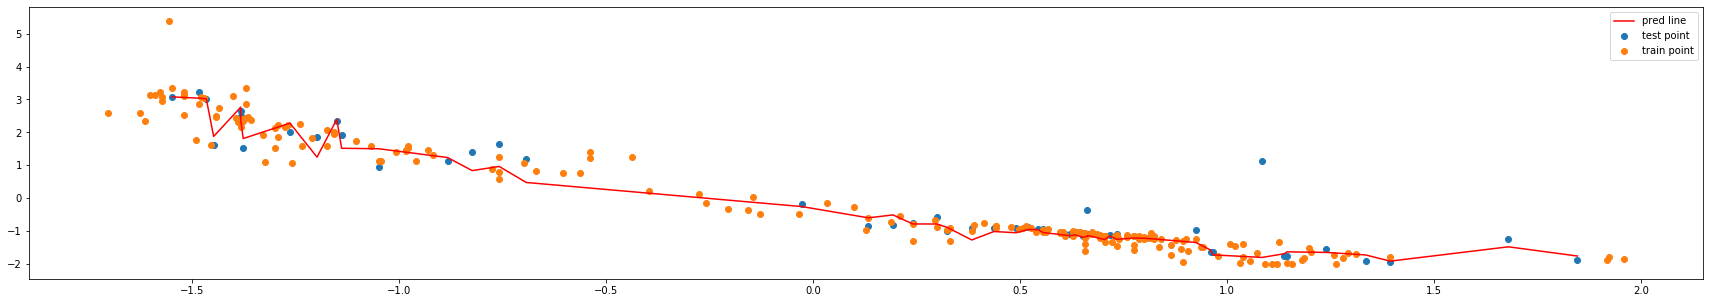

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,5))

#sorted point
test_point = test.sort_values(by='T10')
train_point = train.sort_values(by='T10')

#y_pred line
plt.plot(test_point['T10'],test_point['y_pred'],label='pred line',color='red')

#test point
plt.scatter(test_point['T10'],test_point[y_name],label='test point')

#train point
plt.scatter(train_point['T10'],train_point[y_name],label='train point')

plt.legend()
plt.show()

# check out

In [31]:
loss = (test_point[y_name] - test_point['y_pred'])**2 # 平方誤差
loss.sort_values(ascending=False).head(5)

95     8.629114
60     0.636319
85     0.497537
150    0.479574
100    0.393685
dtype: float64

In [32]:
ub = loss.mean() + 3 * loss.std()
ub

3.90288733421167

In [33]:
out_index = list(loss[loss>ub].index)
out_index

[95]

# del out

In [0]:
#add out columns
test_point['out'] = False
test_point.loc[out_index ,'out'] = True

#def out_point
out_point = test_point[test_point['out'] == True]

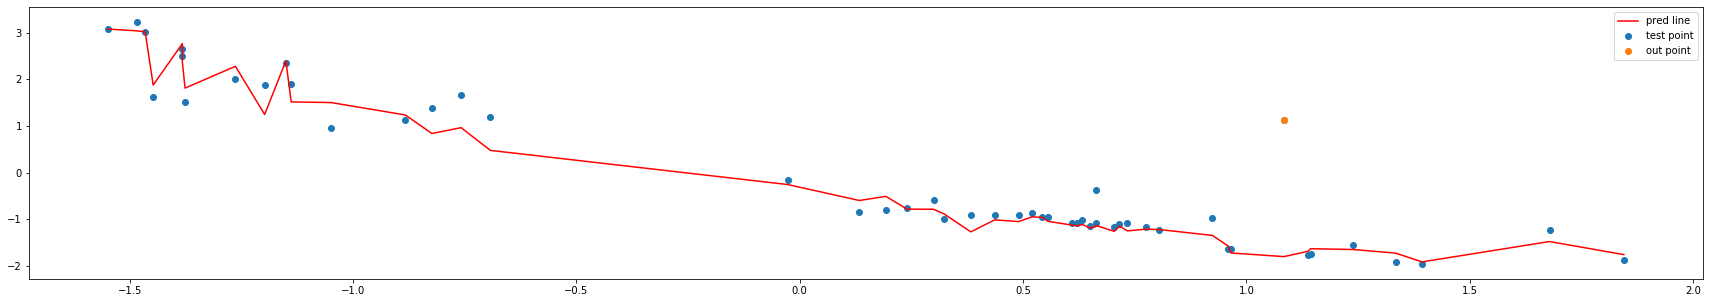

In [35]:
#fig
fig = plt.figure(figsize=(30,5))

#y_pred line
plt.plot(test_point['T10'],test_point['y_pred'],label='pred line',color='red')

#test point
plt.scatter(test_point['T10'],test_point[y_name],label='test point')

#out point
plt.scatter(out_point['T10'],out_point[y_name],label='out point')

plt.legend()
plt.show()

# del_out_point_scores:

In [36]:
print('del_out_point_scores:')
metric(test_point.loc[test_point['out'] == False ,y_name],test_point.loc[test_point['out'] == False ,'y_pred'])

del_out_point_scores:


,R2,RMSE,mean_absolute_error
V1,0.968122,0.27926,0.195029


# all scores

In [0]:
y_pred_all = pd.DataFrame(scaler_y.inverse_transform(pca.inverse_transform(test[[y_name]])),index=test.index,columns=y_columns)
y_test_all = test[y_columns]

In [38]:
res = pd.DataFrame()
for i in y_columns:
  res = res.append(metric(y_test_all[i],y_pred_all[i]))
res.loc['AVG'] = res.mean()
res

,R2,RMSE,mean_absolute_error
C5NP,0.968140,0.696313,0.529057
C5IP,0.972815,0.442322,0.320035
C5N,0.963651,0.058450,0.050356
AVG,0.968202,0.399028,0.299816


# del out all scores

In [39]:
print(out_index)
y_pred_all = y_pred_all.drop(out_index,axis=0)
y_test_all = y_test_all.drop(out_index,axis=0)

[95]


In [40]:
res = pd.DataFrame()
for i in y_columns:
  res = res.append(metric(y_test_all[i],y_pred_all[i]))
res.loc['AVG'] = res.mean()
res

,R2,RMSE,mean_absolute_error
C5NP,0.967760,0.703357,0.539004
C5IP,0.974988,0.427681,0.308088
C5N,0.964846,0.057359,0.049383
AVG,0.969198,0.396132,0.298825
